## loading some digi rocks into napari 

using https://www.digitalrocksportal.org/projects/161 as a test data set 



this example loads in the smaller medical CT scan and does some pre-processing before loading into napari 

# pre-processing

The main goal of the pre-processing is to mask out pixels outside the sample: since the exterior of the sample has intensity values of 0, if you simply load the image into napari then you can't distinguish interior points with intensity of 0 (the pore spaces) from points outside of the sample when viewing in 3D. So in the pre-processing here, for each height in the image, I mask points falling outside a circle (the radius is an adjustable parameter) by setting them to NaN. This allows you to invert the image and have a 3D visualization that just captures the pore space.

Where this gets tricky is that loading in the raw 3D image arrays shows a vertical offset. Since the digital rock portals `.gif` file shows serial sections that do not appear to shift in center, I assumed that this vertical offset needed to be corrected. That might not be the case... but in any case, that's what I did. So in summary, the pre-processing steps here are: 

1. vertically-align the layers (calculate and apply x, y offsets at each z so that they maximize the overlap with a reference layer)
2. calculate the sample diameter and center at each height, find average sample diameter and center across all heights
3. set image values for pixels falling outside the average diameter to NaN

## initially load data 

NOTE: I'm using yt for convenience here since that's where I tend to store datasets. you can replace the following cell with any path you like (and not use yt at all for this)

In [1]:
from yt.config import ytcfg
import os
data_dir = os.path.join(ytcfg.get("yt", "test_data_dir"), "digi_rocks/guelph_dolomite/161/origin/574/images") # the medical CT directory
filename = os.path.join(data_dir, 'medicalCT_192_202_288_8bit.raw')

load into an array (note reverse order width, height, slice)

In [2]:
import numpy as np 

shp = (288, 202, 192) # from file name
with open(filename,'rb') as f:
    img_arr=np.fromfile(f,dtype=np.uint8)
img_arr=img_arr.reshape(*shp)
img_arr.shape

(288, 202, 192)

check that it's sensible before loading into napari

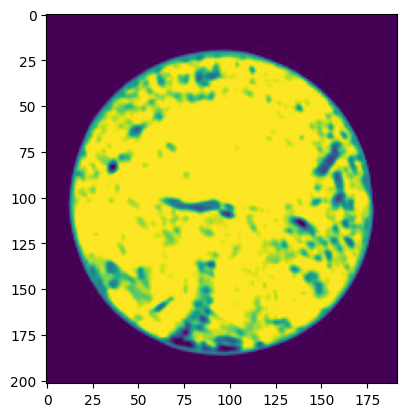

In [3]:
import matplotlib.pyplot as plt 

plt.imshow(img_arr[100, :, :])

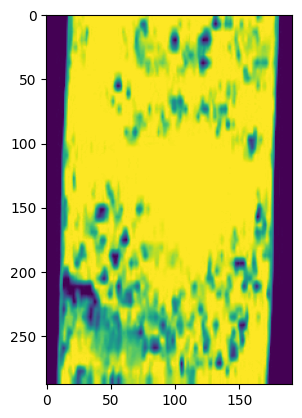

In [4]:
plt.imshow(img_arr[:, 100, :])

looks like the raw images are offset in the slice direction... need to align those?

plot the log to make it jump out

/tmp/ipykernel_1070886/951983516.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_arr[0,:,:]))


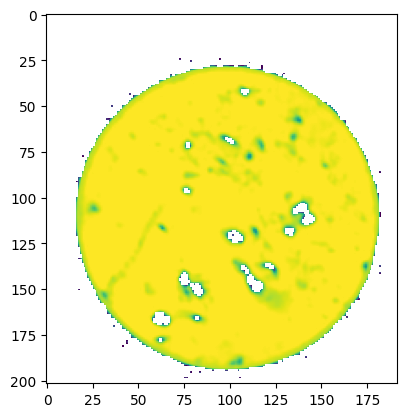

In [5]:
plt.imshow(np.log10(img_arr[0,:,:]))

/tmp/ipykernel_1070886/3826401982.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_arr[200,:,:]))


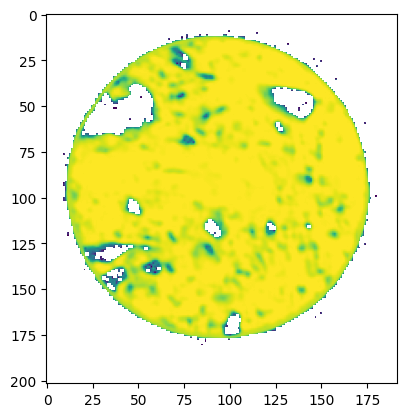

In [6]:
plt.imshow(np.log10(img_arr[200,:,:]))

those errant nonzeros will be annoying... 

## vertical alignment

so we presumably want to align the vertical layers (if not, we can simplify some of this)...

Lots of possible ways. In this example, I'll pick a reference layer and calculate the x and y pixel offsets by maximizing the coherence between the x and y sums over the image. 

For the reference layer

In [7]:
ref_layer = img_arr[0,:,:]

the sum over the x or y axis will give the shadow the circle projected on each axis

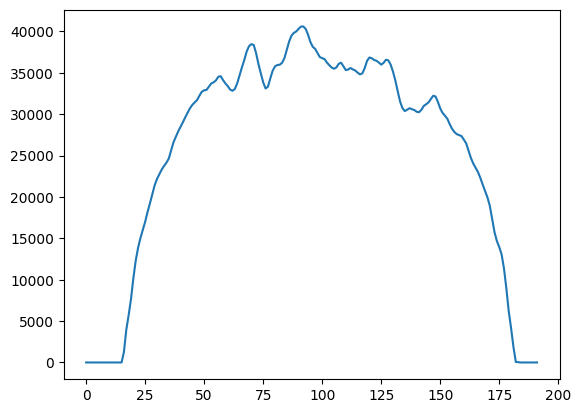

In [8]:
ref_ax_0_sum = np.sum(ref_layer, axis=0)
ref_ax_1_sum = np.sum(ref_layer, axis=1)
plt.plot(ref_ax_0_sum)

so we can write a fucntion to take an image layer and find the offset along one dimension by finding the offset that maximes the product of the reference and the layer:

In [9]:
def find_offset(im, ax, ref_ax_sum):
    # brute force search for offset that maximizes alignment
    ax_sum = np.sum(im, axis=ax)
    coherence = []
    for offset in range(len(ax_sum)):
        test_offset = np.roll(ax_sum, offset)
        coherence.append(np.sum(test_offset*ref_ax_sum))
    
    return np.argmax(coherence)

offset_0  = find_offset(img_arr[200, :, :], 0, ref_ax_0_sum)
offset_1  = find_offset(img_arr[200, :, :], 1, ref_ax_1_sum)

(offset_0, offset_1)
    

(3, 16)

and now a wrapper function to apply it to each dimension of a layer

In [10]:
def shift_layer(im, ref_ax_0_sum, ref_ax_1_sum):
    offset_0  = find_offset(im, 0, ref_ax_0_sum)
    offset_1  = find_offset(im, 1, ref_ax_1_sum)

    # note: need to swap axes for final shift! 
    im = np.roll(im, offset_0, axis=1)
    im = np.roll(im, offset_1, axis=0)
    return im 

In [11]:
im_shifted = shift_layer(img_arr[200, :, :], ref_ax_0_sum, ref_ax_1_sum)

make sure it works...

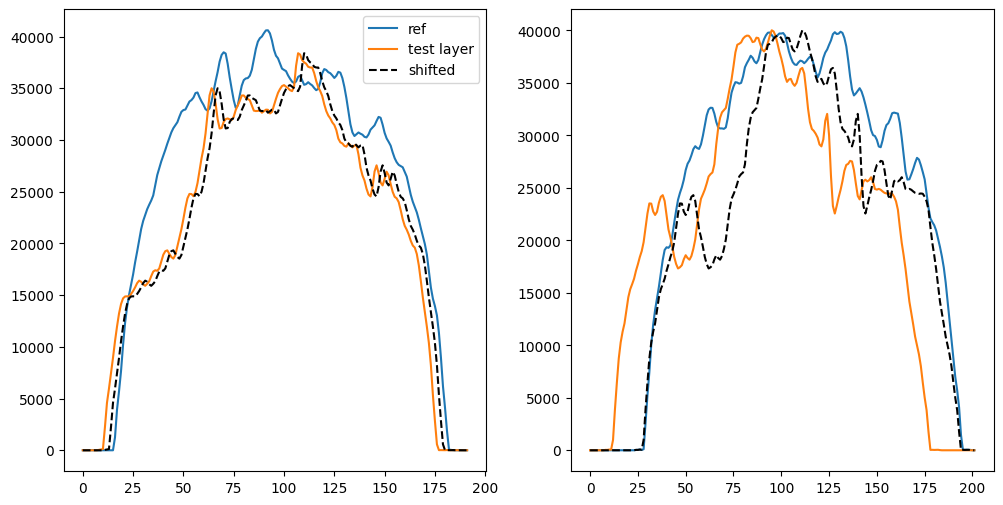

In [12]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axs[0].plot(ref_ax_0_sum, label='ref')
axs[0].plot(np.sum(img_arr[200, :, :], axis=0), label='test layer')
axs[0].plot(np.sum(im_shifted, axis=0), '--k', label='shifted')
axs[0].legend()
axs[1].plot(ref_ax_1_sum)
axs[1].plot(np.sum(img_arr[200, :, :], axis=1))
axs[1].plot(np.sum(im_shifted, axis=1), '--k')


not bad... probably could improved it a bit... but good enough for now. Let's apply it to each z height:

In [13]:
%%time
img_arr_aligned = img_arr.copy()
for iz in range(img_arr.shape[0]):
    img_arr_aligned[iz, :, :] = shift_layer(img_arr_aligned[iz, :, :], ref_ax_0_sum, ref_ax_1_sum)


CPU times: user 1.7 s, sys: 1.6 ms, total: 1.7 s
Wall time: 1.7 s


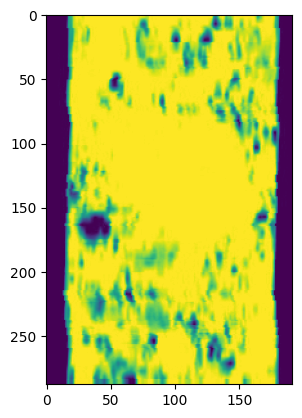

In [14]:
plt.imshow(img_arr_aligned[:, 100, :])

## masking outside the sample 

for 3D viz, we want to mask everything outside the sample to NaN vals so that they don't disrupt the view. 

Since we aligned the layers, let's find the average x-y diameters and just clip beyond those bounds. Since there's some wiggle in the alignment we'll clip some of the sample boundary... not ideal, but for initial visualizaiton it's ok. 


The 

In [15]:
def find_layer_ax_diameter(im, ax):

    # find the sample diameter and center for a given axis, 
    # ignoring the fact that there are stray non-zero pixels 
    # outside bounds
    ax_sum = np.sum(im, axis=ax)
    px_rng = np.arange(0, len(ax_sum))
    px_max = np.max(px_rng[ax_sum>0]) 
    px_min = np.min(px_rng[ax_sum>0])

    diameter = px_max - px_min
    center = px_min + diameter / 2    
    return diameter, center
    

def find_layer_diameter(im_layer):

    # finds the diameter in x,y and the center in x,y for a given z layer
    diams = []
    centers = []
    for ax_i in range(2):
        d_i, c_i = find_layer_ax_diameter(im_layer, ax_i)
        diams.append(d_i)
        centers.append(c_i)
        
    # again swap since finding from the sum over the other axis
    diams.reverse()
    centers.reverse()
    return diams, centers
    

and now apply it to each layer and calculate the average diameters and center locations

In [16]:
%%time
x_diam = []
x_center = []
y_diam = []
y_center = []
for iz in range(img_arr_aligned.shape[0]):
    diams, centers = find_layer_diameter(img_arr_aligned[iz, :, :])
    
    x_diam.append(diams[0])
    y_diam.append(diams[1])
    x_center.append(centers[0])
    y_center.append(centers[1])

N = len(x_diam)
x_diam = np.sum(x_diam) / N
y_diam = np.sum(y_diam) / N
x_center = np.sum(x_center) / N
y_center = np.sum(y_center) / N

(x_diam, y_diam, x_center, y_center)


CPU times: user 25 ms, sys: 194 µs, total: 25.2 ms
Wall time: 25.3 ms


(173.27083333333334, 172.6875, 110.82291666666667, 98.11805555555556)

First, mask a square just to check 

In [17]:
mask_radius = int(150/2)

In [18]:
im_masked = img_arr_aligned.copy().astype('float')
y_pixs = np.arange(0, img_arr_aligned.shape[2])
x_pixs = np.arange(0, img_arr_aligned.shape[1])

# x_pixs, y_pixs
im_masked[:, x_pixs < x_center - mask_radius, :] = np.nan
im_masked[:, x_pixs > x_center + mask_radius, :] = np.nan
im_masked[:, :, y_pixs < y_center - mask_radius] = np.nan
im_masked[:, :,  y_pixs > y_center + mask_radius] = np.nan


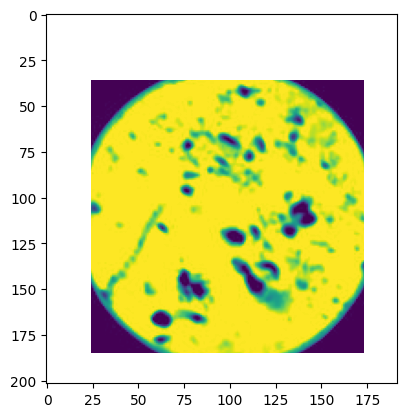

In [19]:
plt.imshow(im_masked[0,:,:])

looks good, let's mask by z layer and radius

In [20]:
im_masked = img_arr_aligned.copy().astype('float')
y_pixs = np.arange(0, img_arr_aligned.shape[2])
x_pixs = np.arange(0, img_arr_aligned.shape[1])
X, Y = np.meshgrid(x_pixs, y_pixs, indexing='ij')
dist = np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2)
msk = dist > mask_radius
for iz in range(img_arr_aligned.shape[0]):
    im_masked[iz, msk] = np.nan 
    

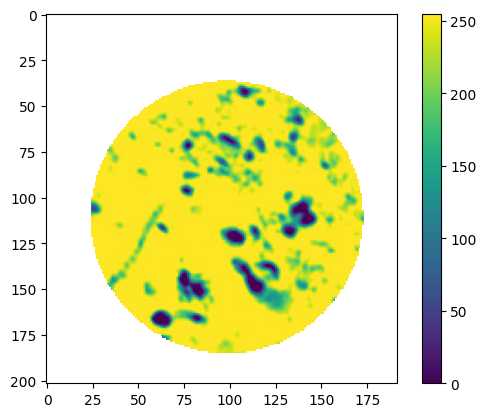

In [21]:
plt.imshow(im_masked[0,:,:])
plt.colorbar()

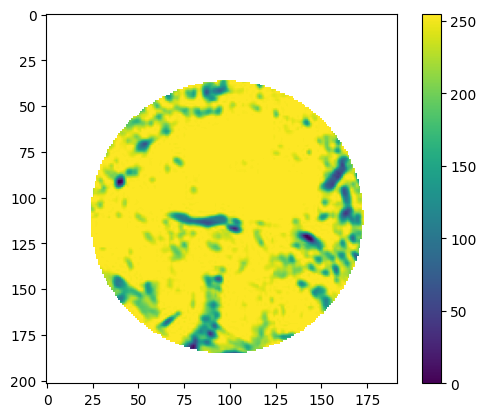

In [22]:
plt.imshow(im_masked[100,:,:])
plt.colorbar()

# Load into napari!

Now ready to load into napari! 

Since what we want to is visualize the pore geometry, let's invert the image. After inverting, we can set the Nan's back to 0 as well! 

In [23]:
inverted_im = 255 - im_masked
inverted_im[~np.isfinite(inverted_im)] = 0.0

In [24]:
import napari 

viewer = napari.Viewer()

Assistant skips harvesting pyclesperanto as it's not installed.


In [25]:
viewer.layers.clear()
viewer.add_image(inverted_im, colormap='viridis', name='inverted')

<Image layer 'inverted' at 0x7f2384311090>

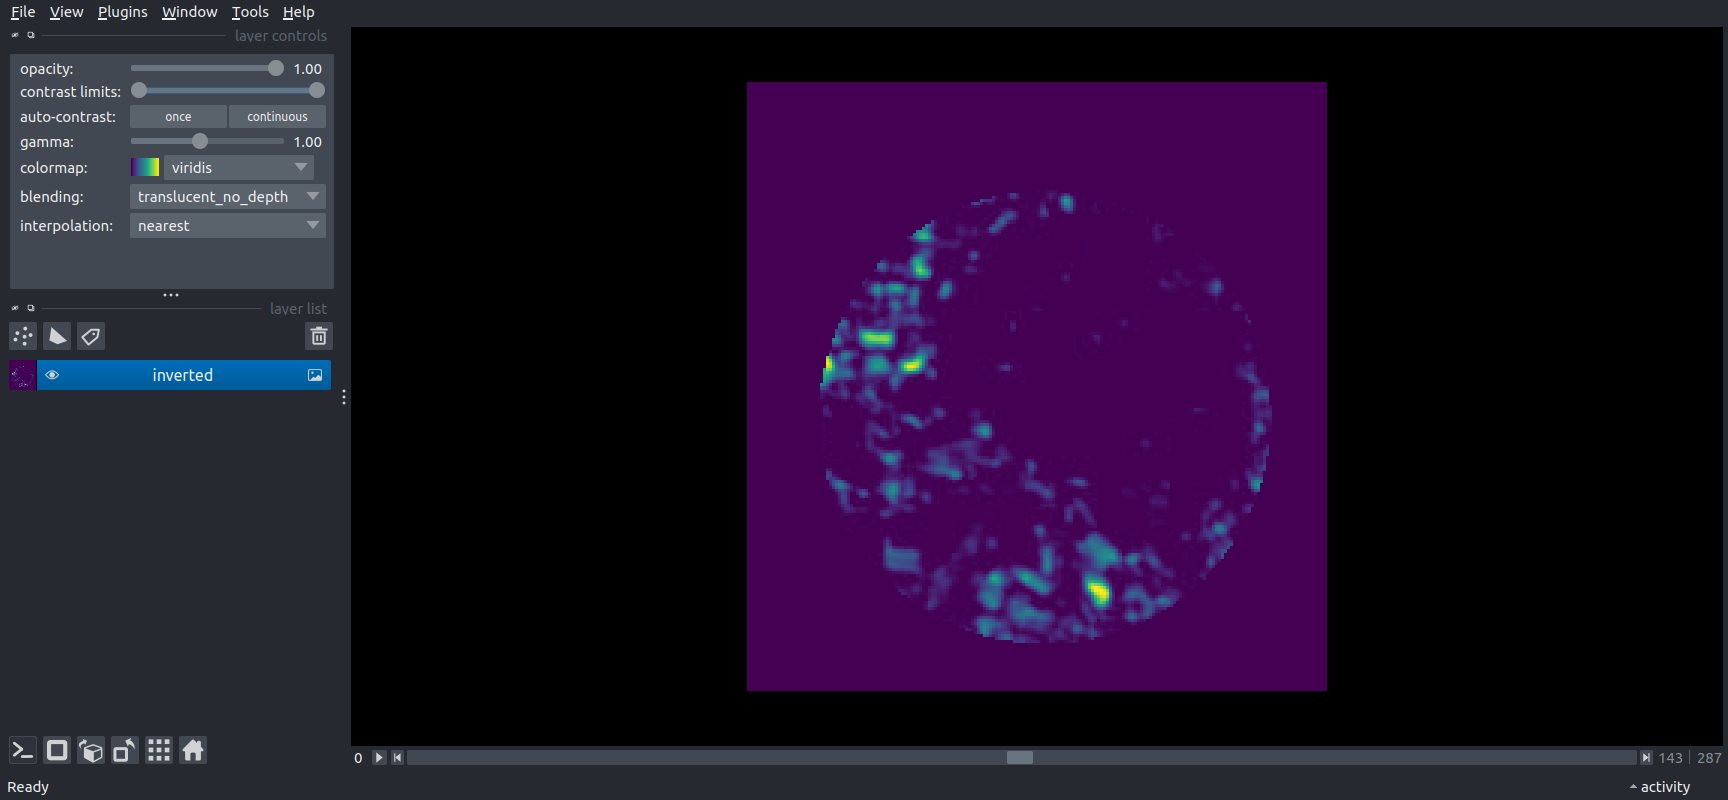

In [26]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

In [27]:
viewer.dims.ndisplay = 3
viewer.layers['inverted'].contrast_limits = (70, 255)

# following values pulled from initial run, set here to have a nice view
viewer.camera.angles = (-166.05586327274904, 41.70081589704753, 21.52699829278922)
viewer.camera.center = (143.5, 100.5, 95.5)
viewer.camera.zoom = 1.7931319690749712

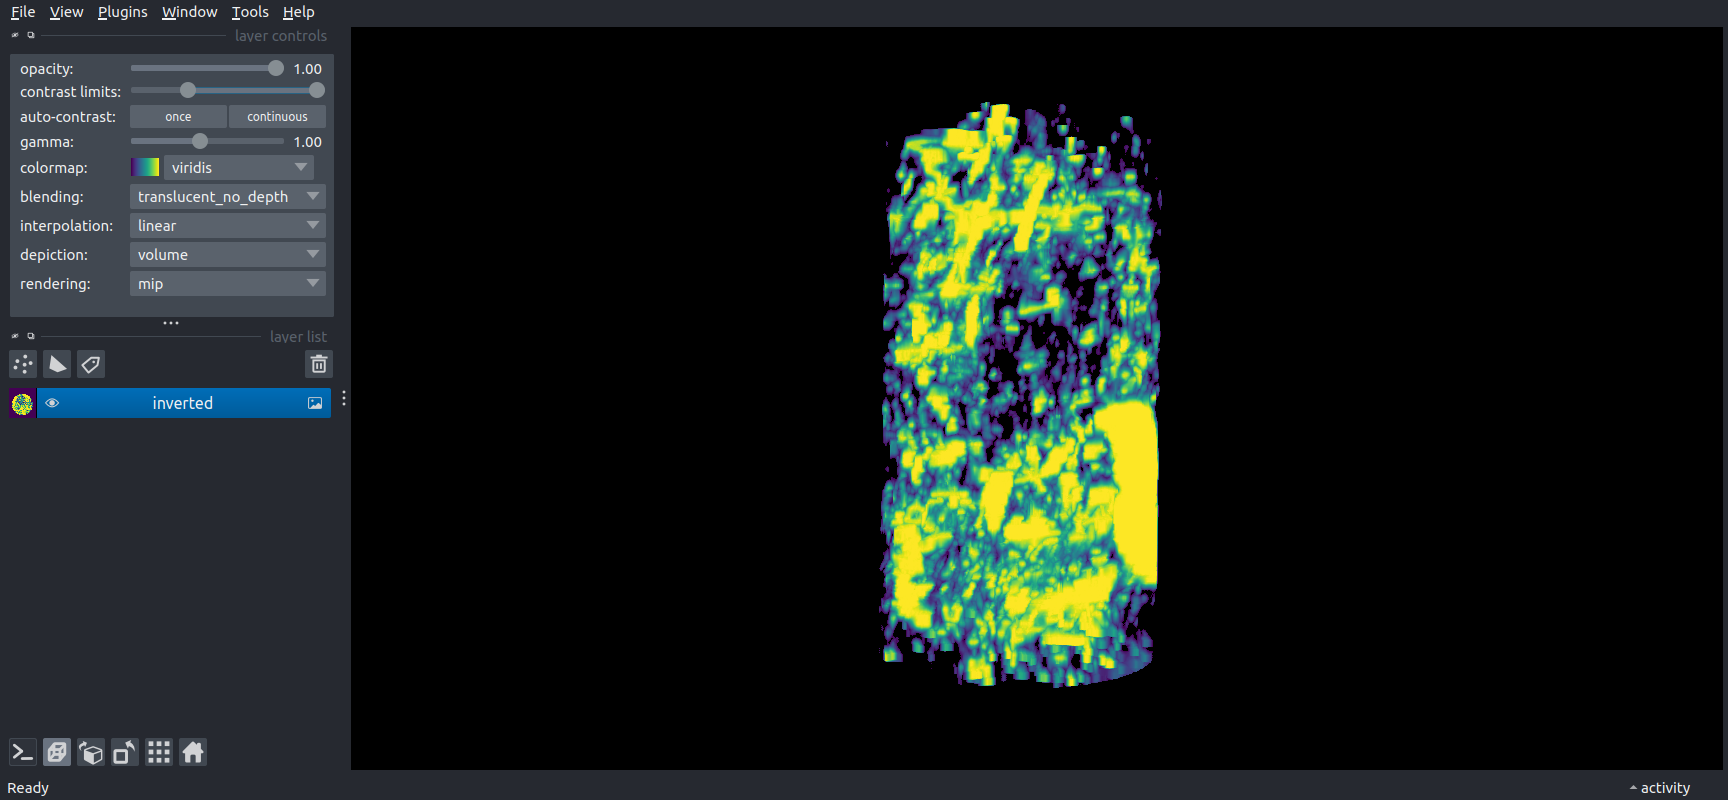

In [28]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)